<a href="https://colab.research.google.com/github/dnjhaha/AML/blob/master/CS680Assign4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Danni Jin CS680 assignment #4
**Caltech-101 is an image dataset of diverse types of objects belonging to 101 categories. There are about 40 to 800 images per category. Most categories have about 50 images.The size of each image is roughly 300 x 200 pixels.**

**The first thing we'll need to do is load in the libraries we'll be using.**

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# For downloading dataset
from urllib.request import urlretrieve
# For extracting dataset
import tarfile
# for sorting dictionary by value
import operator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# for showing images inline
from matplotlib.pyplot import imshow 
%matplotlib inline 

**Download the dataset to a folder inside this directory
This will download the dataset if it has not been downloaded. Further, we extract the dataset as well into /data/ directory in the current working directory.**

In [74]:
URL_CALTECH_101_DATA = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'

def download_dataset(url):
    current_directory = os.path.dirname(os.path.realpath('__file__'))
    dataset_file_path = current_directory+"/dataset.tgz"
    if os.path.exists(dataset_file_path):
        print("Already downloaded.")
    else:
        filename, headers = urlretrieve(url, dataset_file_path)        
    print("Done")

download_dataset(URL_CALTECH_101_DATA)

Already downloaded.
Done


**Because the file form is tar.gz, so we need to extract the file.**

In [76]:
def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("Done")

extract_dataset('./dataset.tgz','./data/')

Done


# Here I didnot resize the image to 32*32 because it is too small, the picture cannot see anything.
**Exploring dataset**
Using image processing programs reduce them to 100 x  100 images 


In [0]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found. Are you sure you downloaded and extracted dataset properly?")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 80x80, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (100,100), interpolation=cv2.INTER_CUBIC)
    return img

**How many images we have for each category?**

In [0]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [79]:
return_images_per_category('./data')

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('trilobite', 86),
 ('starfish', 86),
 ('kangaroo', 86),
 ('sunflower', 85),
 ('buddha', 85),
 ('ewer', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('umbrella', 75),
 ('electric_guitar', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('dalmatian', 67),
 ('flamingo', 67),
 ('ferry', 67),
 ('lotus', 66),
 ('dolphin', 65),
 ('joshua_tree', 64),
 ('euphonium', 64),
 ('elephant', 64),
 ('soccer_ball', 64),
 ('stop_sign', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('rhino', 59),
 ('stegosaurus', 59),
 ('cellphone', 59),
 ('

In [80]:
len(return_images_per_category('./data'))

102

**The number of objects we need to classify is 101. So, we can actually ignore the BACKGROUND_Google directory. we need to convert the dataset into X and Y, wherein X would look something like (num_of_total_images, ROWS, COLS, CHANNELS). The ROWS and COLS need to be fixed, however we have varied sized images. This is why the read_image method above resizes each image to 32x32 which is the average size of images (so most images wouldn't be affected). Y would be (num_of_total_images, 1)**

**What's the total number of images we need in our dataset?**

In [81]:
total_count = 0
for category,count in return_images_per_category('./data'):
    if category == 'BACKGROUND_Google':
        continue;
    total_count += count
print("Total number of images in training data : ",total_count)

Total number of images in training data :  8677


**Here we drop the 'Background google' category and structure the trainning data.**

In [0]:
def create_training_data(data_directory):
    i = 0
    X = np.ndarray((8677, 100, 100, 3), dtype=np.uint8)
    Y = []
    print("Preparing X and Y for dataset...")
    for category,_ in return_images_per_category(data_directory):
        if category == 'BACKGROUND_Google':
            continue
        print("Processing images of ",category)
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X[i] = read_image(image)
            Y.insert(i,category) 
            i += 1
        print("Images processed : ",i+1," of 8678")
    print("Datasets constructed")
    return X,Y

In [84]:
X, Y = create_training_data('./data')

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  Motorbikes
Images processed :  1599  of 8678
Processing images of  Faces
Images processed :  2034  of 8678
Processing images of  Faces_easy
Images processed :  2469  of 8678
Processing images of  watch
Images processed :  2708  of 8678
Processing images of  Leopards
Images processed :  2908  of 8678
Processing images of  bonsai
Images processed :  3036  of 8678
Processing images of  car_side
Images processed :  3159  of 8678
Processing images of  ketch
Images processed :  3273  of 8678
Processing images of  chandelier
Images processed :  3380  of 8678
Processing images of  hawksbill
Images processed :  3480  of 8678
Processing images of  grand_piano
Images processed :  3579  of 8678
Processing images of  brain
Images processed :  3677  of 8678
Processing images of  butterfly
Images processed :  3768  of 8678
Processing images of  helicopter
Images processed :  3856  o

**Show one of the images.**

In [85]:
X.shape

(8677, 100, 100, 3)

In [86]:
Y[1000]

'Motorbikes'

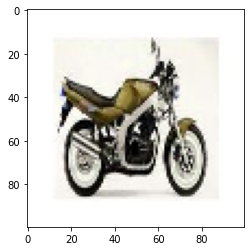

In [87]:
imshow(X[1000])

**Encode the label and scale the input.
Making one-hot encoded labels.**

In [88]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([ 5,  5,  5, ..., 52, 52, 52])

**we need to do one-hot encoding of these data so that it could be provided to machine learning algorithms to do a better job in prediction. One-hot is a group of bits among which the legal combinations of values are only those with a single high bit and all the others low.**

In [0]:
np.save('label_encoder.npy', label_encoder.classes_)

In [90]:
len(Y_integer_encoded)

8677

**Integers have ordering property which we don't want our ML models to learn since an apple isn't in any way greater than an airplane. So, we must create a one-hot encoding.**

In [91]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [92]:
Y_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [93]:
len(Y_one_hot[0])

101

**Basic Normalization (in case of images)**


In [0]:
# Convert the image data to numeric data and normalize them,normalizing inputs from 0-255 to 0.0-1.0 
X_normalized = X.astype(np.float64) / 255

In [95]:
X[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

**Images are comprised of matrices of pixel values. Normally, pixels are expected to have value in the range 0-255. We need to normalize these values to a range between 0 and 1.**

In [96]:
X_normalized[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

**Split training and testing set.**

In [0]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.2, random_state=42)

In [99]:
X_train.shape

(6941, 100, 100, 3)

In [100]:
Y_train.shape

(6941, 101)

**Create a Convolutional Neural networks using Keras to detect the images in the validation set.**

Let’s initialize a convolutional neural network using the sequential model of keras. A simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

In [105]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3,3), activation='relu', input_shape=(100,100,3)))
model_cnn.add(Conv2D(32, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(Conv2D(128, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(101, activation='softmax'))
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61952)            

**Compiling the Model，We need to compile the CNN model before we train it. We can use the compile() method for this. Also, let’s define the learning rate for training.**

In [0]:
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

Categorical_crossentropy will compare the distribution of the predictions with the true distribution. We also set the metrics to accuracy so that we will get the details of the accuracy after training.

**Training the Image Classification Model. Now, it is time to train our model and see its accuracy. We can use the fit() method of keras to train the CNN. Train the data and show the history of loss and accuracy for both training and validation set.**

In [107]:
callbacks = [ModelCheckpoint('cnn_model.h5', monitor='val_acc', save_best_only=True)]
hist=model_cnn.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Train on 6941 samples, validate on 1736 samples
Epoch 1/10
6941/6941 [==============================] - 295s 42ms/sample - loss: 3.0298 - acc: 0.3708 - val_loss: 2.1146 - val_acc: 0.5236
Epoch 2/10
6941/6941 [==============================] - 295s 42ms/sample - loss: 1.1330 - acc: 0.7286 - val_loss: 1.8104 - val_acc: 0.6083
Epoch 3/10
6941/6941 [==============================] - 300s 43ms/sample - loss: 0.2430 - acc: 0.9369 - val_loss: 2.6379 - val_acc: 0.5709
Epoch 4/10
6941/6941 [==============================] - 299s 43ms/sample - loss: 0.0644 - acc: 0.9866 - val_loss: 3.1109 - val_acc: 0.5853
Epoch 5/10
6941/6941 [==============================] - 295s 42ms/sample - loss: 0.0249 - acc: 0.9965 - val_loss: 3.1512 - val_acc: 0.6025
Epoch 6/10
6941/6941 [==============================] - 292s 42ms/sample - loss: 0.0197 - acc: 0.9978 - val_loss: 3.0225 - val_acc: 0.6008
Epoch 7/10
6941/6941 [==============================] - 293s 42ms/sample - loss: 0.0157 - acc: 0.9984 - val_loss: 3.03

In [108]:
acc=model_cnn.evaluate(X_validation,Y_validation)[1]

1736/1736 [==============================] - 19s 11ms/sample - loss: 2.7731 - acc: 0.6112


**Visualizing Accuracy**
Import the relevant package we need to do the visualization

**Graphs to visualize the testing and validation data accuracy.**

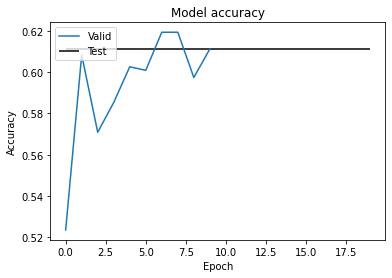

In [109]:
plt.hlines(acc,0,19)
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Valid', 'Test'],loc='upper left')
plt.show()

**According to the plot above, we can see that the accuracy of the validation set has steadily increased and is ultimately consistent with the accuracy of the testing set.**

**Graphs to visualize the training and validation data accuracy.**

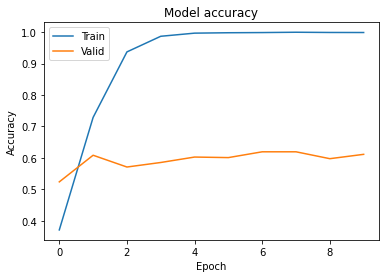

In [110]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'],loc='upper left')
plt.show()

**As we see above, overfitting has happened. After that, the accuracy of the training set continues to rise, but the accuracy of the validation set remains essentially unchanged.**

 **Prediction from models:Accuracy per category**

In [0]:
def find_accuracy_per_category(data_directory, nn_model):
    category_accuracy_dict = {}
    for category,count in return_images_per_category(data_directory):
        correctly_classified = 0
        if category == 'BACKGROUND_Google':
            continue
        Y_category = [category for _ in range(count)]
        encoded = label_encoder.transform(Y_category)
        Y_category = to_categorical(encoded, num_classes=101)
        assert Y_category.shape == (count, 101)
        X_category = np.ndarray((count, 100, 100, 3), dtype=np.float64)
        for i,img in enumerate(get_images(category, data_directory)):
            if not img.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X_category[i] = read_image(img) / 255
        score = nn_model.evaluate(x=X_category, y=Y_category, verbose=1)
        del X_category
        category_accuracy_dict[category] = score
    print("Accuracy found for each class")
    return category_accuracy_dict

In [114]:
# Testing first model
cnn_score_dict = find_accuracy_per_category('./data', model_cnn)

31/31 [==============================] - 0s 11ms/sample - loss: 0.7850 - acc: 0.9677
Accuracy found for each class


In [115]:

average_accuracy = 0
for category, scores in cnn_score_dict.items():
    print(category,":",scores[1])
    average_accuracy += scores[1]
average_accuracy /= 101
print("Average accuracy : ",average_accuracy)

airplanes : 0.995
Motorbikes : 0.9987469
Faces : 0.9885057
Faces_easy : 0.9954023
watch : 0.9790795
Leopards : 0.955
bonsai : 0.9140625
car_side : 0.9756098
ketch : 0.92105263
chandelier : 0.91588783
hawksbill : 0.91
grand_piano : 0.97979796
brain : 0.9183673
butterfly : 0.9120879
helicopter : 0.8181818
menorah : 0.954023
trilobite : 0.96511626
starfish : 0.89534885
kangaroo : 0.872093
sunflower : 0.9411765
buddha : 0.91764706
ewer : 0.87058824
scorpion : 0.85714287
revolver : 0.9634146
laptop : 0.91358024
ibis : 0.8375
llama : 0.85897434
minaret : 0.9605263
umbrella : 0.85333335
electric_guitar : 0.88
crab : 0.9041096
crayfish : 0.87142855
cougar_face : 0.85507244
dragonfly : 0.86764705
dalmatian : 0.86567163
flamingo : 0.9104478
ferry : 0.8358209
lotus : 0.8787879
dolphin : 0.83076924
joshua_tree : 0.921875
euphonium : 0.921875
elephant : 0.859375
soccer_ball : 0.9375
stop_sign : 0.9375
schooner : 0.85714287
chair : 0.87096775
lamp : 0.852459
yin_yang : 0.9
rhino : 0.84745765
stegosa

**So, as we can see, we achieve an average accuracy of 88% per category with our CNN models. This isn't bad. Overall, the model performance is satisfactory. Perhaps adding some convolutional layers can achieve a better result.**